In [61]:
import numpy as np
import pandas as pd
import yahoo_fin.stock_info as si
from scipy.optimize import minimize
from datetime import datetime, timedelta

# Define the assets
stocks = ["AAPL", "ABBV", "ADBE", "AMZN", "AVGO", "BRK-B", "CRM", "COST", "CVX", "HD", 
          "JNJ", "JPM", "LLY", "MA", "META", "MRK", "MSFT", "NVDA", "PG", "TSLA", "UNH", "V", "XOM"]
bonds = ["^TNX", "^TYX"]
reits = ["WELL", "O", "CCI"]

assets = stocks + bonds + reits

# Set date range for the past 10 years
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=10*365)).strftime('%Y-%m-%d')

# Fetch historical data
data = {}
failed_assets = []
for asset in assets:
    try:
        print(f"Fetching data for {asset} from {start_date} to {end_date}")
        data[asset] = si.get_data(asset, start_date=start_date, end_date=end_date)['close']
        print(f"Fetched data for {asset}")
    except Exception as e:
        print(f"Failed to fetch data for {asset}: {e}")
        failed_assets.append(asset)

# Create a DataFrame from the fetched data
price_df = pd.DataFrame(data)

# Fill missing values by forward filling
price_df = price_df.ffill()

# Print the DataFrame to verify
print("Price DataFrame Head:")
print(price_df.head())
print("Price DataFrame Tail:")
print(price_df.tail())

# Drop columns with missing values
price_df = price_df.dropna(axis=1)

# Adjust the assets list based on successfully fetched data
valid_assets = price_df.columns.tolist()

# Ensure there are valid assets before proceeding
if len(valid_assets) == 0:
    raise ValueError("No valid assets fetched. Please check your asset list and data fetching process.")


Fetching data for AAPL from 2014-05-21 to 2024-05-18
Fetched data for AAPL
Fetching data for ABBV from 2014-05-21 to 2024-05-18
Fetched data for ABBV
Fetching data for ADBE from 2014-05-21 to 2024-05-18
Fetched data for ADBE
Fetching data for AMZN from 2014-05-21 to 2024-05-18
Fetched data for AMZN
Fetching data for AVGO from 2014-05-21 to 2024-05-18
Fetched data for AVGO
Fetching data for BRK-B from 2014-05-21 to 2024-05-18
Fetched data for BRK-B
Fetching data for CRM from 2014-05-21 to 2024-05-18
Fetched data for CRM
Fetching data for COST from 2014-05-21 to 2024-05-18
Fetched data for COST
Fetching data for CVX from 2014-05-21 to 2024-05-18
Fetched data for CVX
Fetching data for HD from 2014-05-21 to 2024-05-18
Fetched data for HD
Fetching data for JNJ from 2014-05-21 to 2024-05-18
Fetched data for JNJ
Fetching data for JPM from 2014-05-21 to 2024-05-18
Fetched data for JPM
Fetching data for LLY from 2014-05-21 to 2024-05-18
Fetched data for LLY
Fetching data for MA from 2014-05-21 

In [62]:
# Calculate daily returns
returns_df = price_df.pct_change().dropna()
# Display the head and tail of returns_df to verify
print("Returns DataFrame Head:")
print(returns_df.head())
print("Returns DataFrame Tail:")
print(returns_df.tail())


Returns DataFrame Head:
                AAPL      ABBV      ADBE      AMZN      AVGO     BRK-B  \
2014-05-22  0.001583  0.006758  0.010885 -0.000328  0.003947  0.002526   
2014-05-23  0.011296  0.005967  0.018211  0.024040  0.027228 -0.001418   
2014-05-26  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-05-27  0.018726  0.000741  0.014774 -0.004548  0.005386  0.005678   
2014-05-28 -0.002589  0.001482 -0.006284 -0.002123 -0.011702 -0.000470   

                 CRM      COST       CVX        HD  ...        PG      TSLA  \
2014-05-22  0.061367  0.001834 -0.004269  0.008965  ...  0.001988  0.027225   
2014-05-23  0.002628  0.001830 -0.002103  0.005077  ... -0.001612  0.011812   
2014-05-26  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2014-05-27  0.017787 -0.009309 -0.004296  0.006441  ... -0.005464  0.020550   
2014-05-28 -0.018764  0.003249 -0.002605 -0.000126  ...  0.000250 -0.006239   

                 UNH         V       XOM      ^TNX      

### Conservative Portfolio

In [71]:
# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    # Assuming risk_tolerance_score is already between 0 and 1
    return risk_tolerance_score

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

def get_optimal_weights(mean_returns, cov_matrix, target_risk):
    num_assets = len(mean_returns)
    args = (cov_matrix,)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
        {'type': 'ineq', 'fun': lambda x: target_risk - minimize_volatility(x, cov_matrix)}  # Portfolio risk should be less than or equal to target risk
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification with slightly higher upper bound

    result = minimize(minimize_volatility, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.25  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.19  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, target_risk)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}
# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount


print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.22
Target Risk Level: 0.08300000000000002
Risk-Free Rate: 0.04420000076293945


c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


    Asset  Weight
0    AAPL    0.01
1    ABBV    0.02
2    ADBE    0.01
3    AMZN    0.01
4    AVGO    0.01
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.11
8     CVX    0.01
9      HD    0.01
10    JNJ    0.20
11    JPM    0.01
12    LLY    0.01
13     MA    0.01
14   META    0.01
15    MRK    0.10
16   MSFT    0.01
17   NVDA    0.01
18     PG    0.20
19   TSLA    0.01
20    UNH    0.01
21      V    0.01
22    XOM    0.01
23   ^TNX    0.01
24   ^TYX    0.08
25   WELL    0.01
26      O    0.07
27    CCI    0.02
Expected Portfolio Return: 12.44%
Expected Portfolio Volatility: 14.27%
Sharpe Ratio: 0.56
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.02), ('ADBE', 0.01), ('AMZN', 0.01), ('AVGO', 0.01), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.11), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.2), ('JPM', 0.01), ('LLY', 0.01), ('MA', 0.01), ('META', 0.01), ('MRK', 0.1), ('MSFT', 0.01), ('NVDA', 0.01), ('PG', 0.2), ('TSLA', 0.01), ('UNH', 0.01), ('V', 0.01), ('XOM', 0.01)]
Bonds: [('^

### Balanced Portfolio

In [79]:
# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    # Assuming risk_tolerance_score is already between 0 and 1
    return risk_tolerance_score

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to minimize the difference from target risk
def objective_function(weights, mean_returns, cov_matrix, target_risk):
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    penalty = abs(portfolio_volatility - target_risk)
    return penalty

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.47  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.39  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, target_risk)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.43
Target Risk Level: 0.1145
    Asset  Weight
0    AAPL    0.01
1    ABBV    0.02
2    ADBE    0.01
3    AMZN    0.01
4    AVGO    0.01
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.11
8     CVX    0.01
9      HD    0.01
10    JNJ    0.20
11    JPM    0.01
12    LLY    0.01
13     MA    0.01
14   META    0.01
15    MRK    0.10
16   MSFT    0.01
17   NVDA    0.01
18     PG    0.20
19   TSLA    0.01
20    UNH    0.01
21      V    0.01
22    XOM    0.01
23   ^TNX    0.01
24   ^TYX    0.08
25   WELL    0.01
26      O    0.07
27    CCI    0.02
Expected Portfolio Return: 12.44%
Expected Portfolio Volatility: 14.27%
Sharpe Ratio: 0.56
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.02), ('ADBE', 0.01), ('AMZN', 0.01), ('AVGO', 0.01), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.11), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.2), ('JPM', 0.01), ('LLY', 0.01), ('MA', 0.01), ('META', 0.01), ('MRK', 0.1), ('MSFT', 0.01), ('NVDA', 0.01), ('PG', 0.2), ('TSLA', 0.01),

In [92]:
# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    # Assuming risk_tolerance_score is already between 0 and 1
    return risk_tolerance_score

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to minimize the difference from target risk
def objective_function(weights, mean_returns, cov_matrix, target_risk):
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    penalty = abs(portfolio_volatility - target_risk)
    return penalty

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.75  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.85  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, target_risk)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.8
Target Risk Level: 0.17000000000000004
    Asset  Weight
0    AAPL    0.03
1    ABBV    0.04
2    ADBE    0.03
3    AMZN    0.03
4    AVGO    0.03
5   BRK-B    0.04
6     CRM    0.03
7    COST    0.04
8     CVX    0.03
9      HD    0.03
10    JNJ    0.05
11    JPM    0.03
12    LLY    0.04
13     MA    0.03
14   META    0.03
15    MRK    0.05
16   MSFT    0.03
17   NVDA    0.03
18     PG    0.05
19   TSLA    0.03
20    UNH    0.04
21      V    0.03
22    XOM    0.04
23   ^TNX    0.03
24   ^TYX    0.04
25   WELL    0.04
26      O    0.04
27    CCI    0.04
Expected Portfolio Return: 18.27%
Expected Portfolio Volatility: 16.89%
Sharpe Ratio: 0.82
User's Portfolio:
Stocks: [('AAPL', 0.03), ('ABBV', 0.04), ('ADBE', 0.03), ('AMZN', 0.03), ('AVGO', 0.03), ('BRK-B', 0.04), ('CRM', 0.03), ('COST', 0.04), ('CVX', 0.03), ('HD', 0.03), ('JNJ', 0.04999999999999978), ('JPM', 0.03), ('LLY', 0.04), ('MA', 0.03), ('META', 0.03), ('MRK', 0.05), ('MSFT', 0.03), ('NVDA', 0.03),

In [95]:
# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    # Assuming risk_tolerance_score is already between 0 and 1
    return risk_tolerance_score

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to maximize the Sharpe ratio
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negative to maximize Sharpe ratio

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.20  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.23  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.21500000000000002
Target Risk Level: 0.08225000000000002
Risk-Free Rate: 0.04420000076293945
    Asset  Weight
0    AAPL    0.01
1    ABBV    0.01
2    ADBE    0.01
3    AMZN    0.04
4    AVGO    0.07
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.18
8     CVX    0.01
9      HD    0.01
10    JNJ    0.01
11    JPM    0.01
12    LLY    0.19
13     MA    0.01
14   META    0.01
15    MRK    0.01
16   MSFT    0.01
17   NVDA    0.20
18     PG    0.01
19   TSLA    0.04
20    UNH    0.07
21      V    0.01
22    XOM    0.01
23   ^TNX    0.01
24   ^TYX    0.01
25   WELL    0.01
26      O    0.01
27    CCI    0.01
Expected Portfolio Return: 31.40%
Expected Portfolio Volatility: 20.74%
Sharpe Ratio: 1.30
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.01), ('ADBE', 0.01), ('AMZN', 0.04), ('AVGO', 0.07), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.18), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.01), ('JPM', 0.01), ('LLY', 0.19), ('MA', 0.01), ('META', 0.01), ('MRK', 0

In [99]:
# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    # Assuming risk_tolerance_score is already between 0 and 1
    return risk_tolerance_score

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to balance maximizing Sharpe ratio and achieving target risk
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate, target_risk):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    penalty = abs(portfolio_volatility - target_risk)
    return -sharpe_ratio + penalty  # Negative to maximize Sharpe ratio and penalty to target risk level

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.56  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.75  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.655
Target Risk Level: 0.14825000000000002
Risk-Free Rate: 0.04420000076293945
    Asset  Weight
0    AAPL    0.01
1    ABBV    0.01
2    ADBE    0.01
3    AMZN    0.03
4    AVGO    0.04
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.20
8     CVX    0.01
9      HD    0.01
10    JNJ    0.01
11    JPM    0.01
12    LLY    0.20
13     MA    0.01
14   META    0.01
15    MRK    0.01
16   MSFT    0.01
17   NVDA    0.20
18     PG    0.01
19   TSLA    0.03
20    UNH    0.08
21      V    0.01
22    XOM    0.01
23   ^TNX    0.02
24   ^TYX    0.01
25   WELL    0.01
26      O    0.01
27    CCI    0.01
Expected Portfolio Return: 30.75%
Expected Portfolio Volatility: 20.23%
Sharpe Ratio: 1.30
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.01), ('ADBE', 0.01), ('AMZN', 0.03), ('AVGO', 0.04), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.2), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.01), ('JPM', 0.01), ('LLY', 0.2), ('MA', 0.01), ('META', 0.01), ('MRK', 0.01), ('MSFT', 0

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Composite Risk Profile: 0.79
Target Risk Level: 0.16850000000000004
Risk-Free Rate: 0.04420000076293945


c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


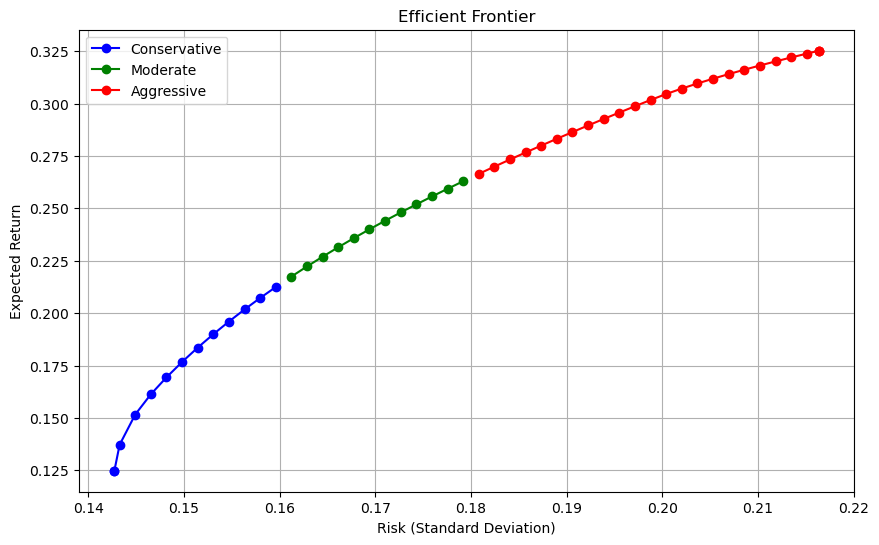

    Asset  Weight
0    AAPL    0.01
1    ABBV    0.01
2    ADBE    0.01
3    AMZN    0.04
4    AVGO    0.01
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.19
8     CVX    0.01
9      HD    0.01
10    JNJ    0.01
11    JPM    0.01
12    LLY    0.20
13     MA    0.01
14   META    0.01
15    MRK    0.05
16   MSFT    0.01
17   NVDA    0.09
18     PG    0.10
19   TSLA    0.02
20    UNH    0.06
21      V    0.01
22    XOM    0.01
23   ^TNX    0.01
24   ^TYX    0.06
25   WELL    0.01
26      O    0.01
27    CCI    0.01
Expected Portfolio Return: 23.60%
Expected Portfolio Volatility: 16.79%
Sharpe Ratio: 1.14
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.01), ('ADBE', 0.01), ('AMZN', 0.04), ('AVGO', 0.01), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.18999999999999978), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.01), ('JPM', 0.01), ('LLY', 0.2), ('MA', 0.01), ('META', 0.01), ('MRK', 0.05), ('MSFT', 0.01), ('NVDA', 0.09), ('PG', 0.1), ('TSLA', 0.02), ('UNH', 0.06), ('V', 0.01), ('XOM', 0.

In [111]:
import matplotlib.pyplot as plt
# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    return risk_tolerance_score  # Assuming risk_tolerance_score is already between 0 and 1

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to maximize the Sharpe ratio and target risk level
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate, target_risk):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    penalty = abs(portfolio_volatility - target_risk)
    return -sharpe_ratio + penalty  # Negative to maximize Sharpe ratio and penalty to target risk level

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
        {'type': 'ineq', 'fun': lambda x: target_risk - minimize_volatility(x, cov_matrix)}  # Ensure portfolio risk <= target risk
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define a function to calculate portfolios for a range of risk levels
def calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=50):
    target_risks = np.linspace(0.14, 0.22, num_portfolios)  # Define a range of target risks
    portfolios = []

    for target_risk in target_risks:
        weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)
        returns, std = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        portfolios.append((std, returns))

    return portfolios

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.80  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.78  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")

# Calculate the efficient frontier
efficient_frontier = calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

# Split the efficient frontier into conservative, moderate, and aggressive sections
conservative_portfolios = [p for p in efficient_frontier if p[0] <= 0.16]
moderate_portfolios = [p for p in efficient_frontier if 0.16 < p[0] <= 0.18]
aggressive_portfolios = [p for p in efficient_frontier if p[0] > 0.18]

# Plot the efficient frontier with sections
plt.figure(figsize=(10, 6))
plt.plot([p[0] for p in conservative_portfolios], [p[1] for p in conservative_portfolios], 'bo-', label='Conservative')
plt.plot([p[0] for p in moderate_portfolios], [p[1] for p in moderate_portfolios], 'go-', label='Moderate')
plt.plot([p[0] for p in aggressive_portfolios], [p[1] for p in aggressive_portfolios], 'ro-', label='Aggressive')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.79
Target Risk Level: 0.16850000000000004
Risk-Free Rate: 0.04420000076293945


c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


    Asset  Weight
0    AAPL    0.01
1    ABBV    0.01
2    ADBE    0.01
3    AMZN    0.04
4    AVGO    0.01
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.19
8     CVX    0.01
9      HD    0.01
10    JNJ    0.01
11    JPM    0.01
12    LLY    0.20
13     MA    0.01
14   META    0.01
15    MRK    0.05
16   MSFT    0.01
17   NVDA    0.09
18     PG    0.10
19   TSLA    0.02
20    UNH    0.06
21      V    0.01
22    XOM    0.01
23   ^TNX    0.01
24   ^TYX    0.06
25   WELL    0.01
26      O    0.01
27    CCI    0.01
Expected Portfolio Return: 23.60%
Expected Portfolio Volatility: 16.79%
Sharpe Ratio: 1.14
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.01), ('ADBE', 0.01), ('AMZN', 0.04), ('AVGO', 0.01), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.18999999999999978), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.01), ('JPM', 0.01), ('LLY', 0.2), ('MA', 0.01), ('META', 0.01), ('MRK', 0.05), ('MSFT', 0.01), ('NVDA', 0.09), ('PG', 0.1), ('TSLA', 0.02), ('UNH', 0.06), ('V', 0.01), ('XOM', 0.

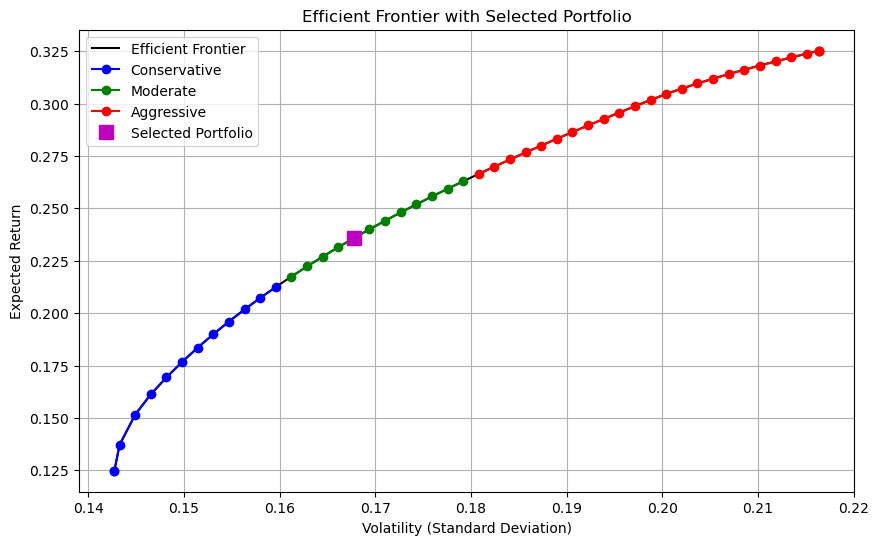

In [133]:
import matplotlib.pyplot as plt

# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    return risk_tolerance_score  # Assuming risk_tolerance_score is already between 0 and 1

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to maximize the Sharpe ratio and target risk level
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate, target_risk):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    penalty = abs(portfolio_volatility - target_risk)
    return -sharpe_ratio + penalty  # Negative to maximize Sharpe ratio and penalty to target risk level

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
        {'type': 'ineq', 'fun': lambda x: target_risk - minimize_volatility(x, cov_matrix)}  # Ensure portfolio risk <= target risk
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define a function to calculate portfolios for a range of risk levels
def calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=50):
    target_risks = np.linspace(0.14, 0.22, num_portfolios)  # Define a range of target risks
    portfolios = []

    for target_risk in target_risks:
        weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)
        returns, std = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        portfolios.append((std, returns, weights))

    return portfolios

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.80  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.78  # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")


# Calculate the efficient frontier
efficient_frontier = calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

# Automatically select the best portfolio based on the target risk level
selected_portfolio = min(efficient_frontier, key=lambda x: abs(x[0] - target_risk))
selected_weights = selected_portfolio[2]

# Filter out assets with non-zero weights
non_zero_weights = selected_weights[selected_weights > 0]
non_zero_assets = np.array(valid_assets)[selected_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")


# Split the efficient frontier into conservative, moderate, and aggressive sections
conservative_portfolios = [p for p in efficient_frontier if p[0] <= 0.16]
moderate_portfolios = [p for p in efficient_frontier if 0.16 < p[0] <= 0.18]
aggressive_portfolios = [p for p in efficient_frontier if p[0] > 0.18]

# Ensure each section has at least one portfolio
if not conservative_portfolios:
    conservative_portfolios.append(efficient_frontier[0])
if not moderate_portfolios:
    moderate_portfolios.append(efficient_frontier[len(efficient_frontier)//2])
if not aggressive_portfolios:
    aggressive_portfolios.append(efficient_frontier[-1])

# Extract weights for the first portfolio in each section
conservative_start = conservative_portfolios[0]
moderate_start = moderate_portfolios[0]
aggressive_start = aggressive_portfolios[0]

# Function to format weights as a percentage string
def format_weights(weights):
    stock_weight = sum(weights[i] for i, asset in enumerate(valid_assets) if asset in stocks)
    bond_weight = sum(weights[i] for i, asset in enumerate(valid_assets) if asset in bonds)
    reit_weight = sum(weights[i] for i, asset in enumerate(valid_assets) if asset in reits)
    return f"{stock_weight:.0%} Stocks, {bond_weight:.0%} Bonds, {reit_weight:.0%} REITs"

conservative_label = format_weights(conservative_start[2])
moderate_label = format_weights(moderate_start[2])
aggressive_label = format_weights(aggressive_start[2])

# Plot the efficient frontier with sections and the selected portfolio
plt.figure(figsize=(10, 6))
plt.plot([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], 'k-', label='Efficient Frontier')
plt.plot([p[0] for p in conservative_portfolios], [p[1] for p in conservative_portfolios], 'bo-', label='Conservative')
plt.plot([p[0] for p in moderate_portfolios], [p[1] for p in moderate_portfolios], 'go-', label='Moderate')
plt.plot([p[0] for p in aggressive_portfolios], [p[1] for p in aggressive_portfolios], 'ro-', label='Aggressive')
plt.plot(selected_portfolio[0], selected_portfolio[1], 'ms', markersize=10, label='Selected Portfolio')  # Highlight the selected portfolio

# Add labels for the starting points of each section
plt.text(conservative_start[0], conservative_start[1], conservative_label, fontsize=9, ha='left')
plt.text(moderate_start[0], moderate_start[1], moderate_label, fontsize=9, ha='left')
plt.text(aggressive_start[0], aggressive_start[1], aggressive_label, fontsize=9, ha='left')

plt.title('Efficient Frontier with Selected Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

### KEEP

In [104]:
# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    return risk_tolerance_score  # Assuming risk_tolerance_score is already between 0 and 1

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to maximize the Sharpe ratio and target risk level
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate, target_risk):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    penalty = abs(portfolio_volatility - target_risk)
    return -sharpe_ratio + penalty  # Negative to maximize Sharpe ratio and penalty to target risk level

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
        {'type': 'ineq', 'fun': lambda x: target_risk - minimize_volatility(x, cov_matrix)}  # Ensure portfolio risk <= target risk
    )
    bounds = tuple((0.01, 0.20) for asset in range(num_assets))  # Enforce diversification

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.80  # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.78  # Example risk capacity


# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")

# Get the optimal weights based on the target risk level
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)

# Filter out assets with non-zero weights
non_zero_weights = optimal_weights[optimal_weights > 0]
non_zero_assets = np.array(valid_assets)[optimal_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

Composite Risk Profile: 0.79
Target Risk Level: 0.16850000000000004
Risk-Free Rate: 0.04420000076293945
    Asset  Weight
0    AAPL    0.01
1    ABBV    0.01
2    ADBE    0.01
3    AMZN    0.04
4    AVGO    0.01
5   BRK-B    0.01
6     CRM    0.01
7    COST    0.19
8     CVX    0.01
9      HD    0.01
10    JNJ    0.01
11    JPM    0.01
12    LLY    0.20
13     MA    0.01
14   META    0.01
15    MRK    0.05
16   MSFT    0.01
17   NVDA    0.09
18     PG    0.10
19   TSLA    0.02
20    UNH    0.06
21      V    0.01
22    XOM    0.01
23   ^TNX    0.01
24   ^TYX    0.06
25   WELL    0.01
26      O    0.01
27    CCI    0.01
Expected Portfolio Return: 23.60%
Expected Portfolio Volatility: 16.79%
Sharpe Ratio: 1.14
User's Portfolio:
Stocks: [('AAPL', 0.01), ('ABBV', 0.01), ('ADBE', 0.01), ('AMZN', 0.04), ('AVGO', 0.01), ('BRK-B', 0.01), ('CRM', 0.01), ('COST', 0.18999999999999978), ('CVX', 0.01), ('HD', 0.01), ('JNJ', 0.01), ('JPM', 0.01), ('LLY', 0.2), ('MA', 0.01), ('META', 0.01), ('MRK', 0.

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


### Aggressive Portfolio